In [ ]:
!git clone https://github.com/Mr-Patty/bimodal-emotion-recognition
!pip install soundfile

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

In [ ]:
!cp drive/'My Drive'/EmotionRecognition/bimodal-emotion-recognition.tar.gz bimodal-emotion-recognition/
%cd bimodal-emotion-recognition
!tar -C . -xzf bimodal-emotion-recognition.tar.gz
!rm bimodal-emotion-recognition.tar.gz
!mv Audio_ogg_10 Audio_preprocess

In [1]:
import wave
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import math
import librosa
import json
import wave
import sys
import pickle
import sklearn

import urllib.request

import librosa.display
import scipy, matplotlib.pyplot as plt, IPython.display as ipd

from scipy.io import wavfile

import librosa.display
import soundfile as sf

import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import os
import matplotlib.style as ms
from tqdm import tqdm
import random

from utils import *
ms.use('seaborn-muted')
%matplotlib inline

In [2]:
from multiprocessing import Pool, Lock, Value
from functools import wraps, reduce
mutex = Lock()
n_processed = Value('i', 0)

def logger(func):
    @wraps(func)
    def wrapper(*args, **kwds):
        res = func(*args, **kwds)
        with mutex:
            global n_processed
            n_processed.value += 1
            if n_processed.value % 5 == 0:
                print(f"\r{n_processed.value} pages are processed...",
                      end='', flush=True)
        return res
    return wrapper

In [3]:
@logger
def feature_extraction(file_emo):
    file, emo = file_emo
    wav_file_name = 'Audio_ogg_10/' + file + '.ogg'
    label = emotion_dict[emo]
    y, _sr = librosa.load(wav_file_name, sr=48000)

    feature_list = [wav_file_name, label]  # wav_file, label
    sig_mean = np.mean(abs(y))
    feature_list.append(sig_mean)  # sig_mean
    feature_list.append(np.std(y))  # sig_std

    rmse = librosa.feature.rms(y + 0.0001)[0]
    feature_list.append(np.mean(rmse))  # rmse_mean
    feature_list.append(np.std(rmse))  # rmse_std

    silence = 0
    for e in rmse:
        if e <= 0.4 * np.mean(rmse):
            silence += 1
    silence /= float(len(rmse))
    feature_list.append(silence)  # silence

    y_harmonic = librosa.effects.hpss(y)[0]
    feature_list.append(np.mean(y_harmonic) * 1000)  # harmonic (scaled by 1000)

    # based on the pitch detection algorithm mentioned here:
    # http://access.feld.cvut.cz/view.php?cisloclanku=2009060001
    # cl = 0.45 * sig_mean
    # center_clipped = []
    # for s in y:
    #     if s >= cl:
    #         center_clipped.append(s - cl)
    #     elif s <= -cl:
    #         center_clipped.append(s + cl)
    #     elif np.abs(s) < cl:
    #         center_clipped.append(0)
    # auto_corrs = librosa.core.autocorrelate(np.array(center_clipped))
    # feature_list.append(1000 * np.max(auto_corrs)/len(auto_corrs))  # auto_corr_max (scaled by 1000)
    # feature_list.append(np.std(auto_corrs))  # auto_corr_std

    return feature_list

In [4]:
@logger
def feature_extraction_next(file_emo):
    file, emo = file_emo
    wav_file_name = 'Audio_ogg_10/' + file + '.ogg'
    label = emotion_dict[emo]
    y, _sr = librosa.load(wav_file_name, sr=48000)

    feature_list = [wav_file_name, label]  # wav_file, label
    sig_mean = np.mean(abs(y))
    feature_list.append(sig_mean)  # sig_mean
    feature_list.append(np.std(y))  # sig_std

#     rmse = librosa.feature.rms(y + 0.0001)[0]
#     feature_list.append(np.mean(rmse))  # rmse_mean
#     feature_list.append(np.std(rmse))  # rmse_std

#     silence = 0
#     for e in rmse:
#         if e <= 0.4 * np.mean(rmse):
#             silence += 1
#     silence /= float(len(rmse))
#     feature_list.append(silence)  # silence

#     y_harmonic = librosa.effects.hpss(y)[0]
#     feature_list.append(np.mean(y_harmonic) * 1000)  # harmonic (scaled by 1000)

    # based on the pitch detection algorithm mentioned here:
    # http://access.feld.cvut.cz/view.php?cisloclanku=2009060001
    cl = 0.45 * sig_mean
    center_clipped = []
    for s in y:
        if s >= cl:
            center_clipped.append(s - cl)
        elif s <= -cl:
            center_clipped.append(s + cl)
        elif np.abs(s) < cl:
            center_clipped.append(0)
    auto_corrs = librosa.core.autocorrelate(np.array(center_clipped))
    feature_list.append(1000 * np.max(auto_corrs)/len(auto_corrs))  # auto_corr_max (scaled by 1000)
    feature_list.append(np.std(auto_corrs))  # auto_corr_std

    return feature_list

In [5]:
labels_df = pd.read_csv('df_prep.csv').to_numpy()
# columns = ['wav_file', 'label', 'sig_mean', 'sig_std', 'rmse_mean', 'rmse_std', 'silence', 'harmonic', 'auto_corr_max', 'auto_corr_std']
columns = ['wav_file', 'label','sig_mean', 'sig_std', 'auto_corr_max', 'auto_corr_std']
df_features = pd.DataFrame(columns=columns)

In [ ]:
res = []
n_processed.value = 0
for i in range(10):
    with Pool(processes=5) as pool: 
        res_tmp = pool.map(feature_extraction_next, labels_df[i*1000:(i+1)*1000])
        res += res_tmp
with Pool(processes=5) as pool:
    res_tmp = pool.map(feature_extraction_next, labels_df[10000:])
    res += res_tmp

In [ ]:
# res

In [ ]:
for i in res:
    x = [i[0][13:-4]] + i[1:]
    df_features = df_features.append(pd.DataFrame(x, index=columns).transpose(), ignore_index=True)

In [ ]:
df_features.head()

In [ ]:
df_features.to_csv('audio_features_2.csv', index=False)

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import pickle
import matplotlib
import matplotlib.pyplot as plt
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.class_weight import compute_class_weight
import itertools
from utils import *

In [2]:
df_features = pd.read_csv('audio_features.csv')

In [3]:
scalar = MinMaxScaler()
df_features[df_features.columns[2:]] = scalar.fit_transform(df_features[df_features.columns[2:]])
df_features.head()

,wav_file,label,sig_mean,sig_std,rmse_mean,rmse_std,silence,harmonic
0,00000_22dec_D62_1_mic,0,0.086199,0.149982,0.089917,0.216245,0.667636,0.336260
1,00001_22dec_D62_1_mic,0,0.074748,0.124903,0.078129,0.177891,0.668384,0.342908
2,00002_22dec_D62_1_mic,0,0.189439,0.194287,0.197853,0.186369,0.334994,0.355700
3,00003_22dec_D62_1_mic,0,0.072606,0.135228,0.075778,0.198685,0.694275,0.338951
4,00004_22dec_D62_1_mic,0,0.069104,0.078659,0.073825,0.085531,0.379920,0.345990


In [4]:
x_train, x_test = train_test_split(df_features, test_size=0.20)

x_train.to_csv('audio_train.csv', index=False)
x_test.to_csv('audio_test.csv', index=False)
y_train = x_train['label'].astype('int')
y_test = x_test['label'].astype('int')

print(x_train.shape, x_test.shape)
del x_train['label']
del x_test['label']
del x_train['wav_file']
del x_test['wav_file']

(8181, 8) (2046, 8)


Test Set Accuracy =  0.302
Test Set F-score =  0.274
Test Set Precision =  0.302
Test Set Recall =  0.274
Confusion matrix, without normalization
[[ 99  15 107   7  16  45  16]
 [ 23  37  78  13   5  37  22]
 [ 65  13 249  15  25  64  48]
 [ 15   9  73  33  10  24  29]
 [ 51   7  90  15  34  34  15]
 [ 50  10 155  20  24  59  44]
 [  8  15  72  20   3  22 106]]


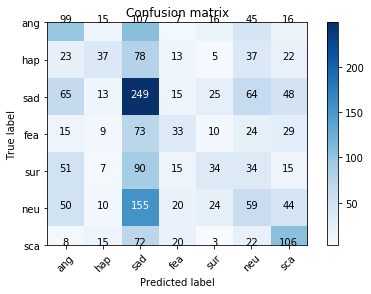

In [6]:
rf_classifier = RandomForestClassifier(n_estimators=1200, min_samples_split=25)
rf_classifier.fit(x_train, y_train)

# Predict
pred_probs = rf_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('rf_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)